In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [2]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

In [5]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [6]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [7]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [8]:

from sklearn.feature_selection import RFECV
from sklearn.metrics import f1_score
from imblearn.metrics import specificity_score



def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Random Forest Classifier

In [9]:
FINAL_FEATURE_SET = REDUCED_FEATURE_SET + SKNACE_ONE_HOT

In [10]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline



Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values



# X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
#     X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Assuming X_train_valid_imbalanced and y_train_valid_imbalanced are already defined
# Count the number of samples in each class
counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

# Calculate the number of samples needed for the majority class (class 0) to achieve a 3:2 ratio
minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

# Define the sampling strategy for RandomUnderSampler
sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

# Apply RandomUnderSampler with the defined sampling strategy
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)



Original class distribution: Counter({0.0: 5183, 1.0: 567})


In [11]:
print('\nTEST')
print(pd.Series(y_test_balanced).value_counts())
print(pd.Series(y_test_imbalanced).value_counts())

print('\nTRAIN')
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_imbalanced).value_counts())

print('\nTRAIN W VALID')
print(pd.Series(y_train_valid_balanced).value_counts())
print(pd.Series(y_train_valid_imbalanced).value_counts())

print('\nVALID')
print(pd.Series(y_valid_valid_imbalanced).value_counts())


TEST
0.0    258
1.0    172
dtype: int64
0.0    1625
1.0     172
dtype: int64

TRAIN
0.0    1050
1.0     700
dtype: int64
0.0    6488
1.0     700
dtype: int64

TRAIN W VALID
0.0    850
1.0    567
dtype: int64
0.0    5183
1.0     567
dtype: int64

VALID
0.0    1305
1.0     133
dtype: int64


In [12]:
from sklearn.model_selection import GridSearchCV

In [24]:
from sklearn.neural_network import MLPClassifier

# Define the parameter grid for MLP
param_grid = {
    'hidden_layer_sizes':[
        (13),
        (3, 3), (4, 3),
        (5, 5), (5, 3),
        (7, 5),
        (9, 5),
        (5, 5, 5),
        (7, 5, 3),
        (10, 10, 10)
    ],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [1e-05, 0.0001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 500, 1000, 2000]
}



# Create an MLP classifier
mlp_classifier = MLPClassifier(random_state=37)

grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=37), n_jobs=4,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [1e-05, 0.0001],
                         'hidden_layer_sizes': [13, (3, 3), (4, 3), (5, 5),
                                                (5, 3), (7, 5), (9, 5),
                                                (5, 5, 5), (7, 5, 3),
                                                (10, 10, 10)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 500, 1000, 2000],
                         'solver': ['adam']},
             scoring='f1', verbose=10)

In [25]:
grid_search.best_params_

{'activation': 'relu',
 'alpha': 1e-05,
 'hidden_layer_sizes': (5, 5, 5),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'solver': 'adam'}

In [26]:
# Extract grid search results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display grid search results
# print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])

# Sort by rank to see the best combinations first
sorted_cv_results = cv_results.query('mean_test_score >= 0.65').sort_values(by='rank_test_score')
sorted_cv_results.head(40)




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
279,3.734185,0.755595,0.001803,0.000404,relu,0.00001,"(5, 5, 5)",adaptive,2000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664151,0.699248,0.618321,0.620155,0.676580,0.655691,0.031826,1
274,3.846605,0.736985,0.002188,0.000740,relu,0.00001,"(5, 5, 5)",constant,2000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664151,0.699248,0.618321,0.620155,0.676580,0.655691,0.031826,1
273,3.747374,0.727069,0.002418,0.000483,relu,0.00001,"(5, 5, 5)",constant,1000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664151,0.699248,0.618321,0.620155,0.676580,0.655691,0.031826,1
278,3.964240,0.893058,0.001820,0.000756,relu,0.00001,"(5, 5, 5)",adaptive,1000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664151,0.699248,0.618321,0.620155,0.676580,0.655691,0.031826,1
277,3.113810,0.072948,0.002027,0.000632,relu,0.00001,"(5, 5, 5)",adaptive,500,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664122,0.708955,0.606061,0.622047,0.676580,0.655553,0.037255,5
272,2.930398,0.087373,0.002185,0.000731,relu,0.00001,"(5, 5, 5)",constant,500,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.664122,0.708955,0.606061,0.622047,0.676580,0.655553,0.037255,5
218,1.612826,0.103433,0.006793,0.008320,relu,0.00001,"(3, 3)",adaptive,1000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.637795,0.713755,0.636015,0.629921,0.651515,0.653800,0.030797,7
219,1.659614,0.127252,0.000281,0.000561,relu,0.00001,"(3, 3)",adaptive,2000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.637795,0.713755,0.636015,0.629921,0.651515,0.653800,0.030797,7
214,1.618546,0.106094,0.000399,0.000798,relu,0.00001,"(3, 3)",constant,2000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.637795,0.713755,0.636015,0.629921,0.651515,0.653800,0.030797,7
213,1.650431,0.093866,0.000000,0.000000,relu,0.00001,"(3, 3)",constant,1000,adam,"{'activation': 'relu', 'alpha': 1e-05, 'hidden...",0.637795,0.713755,0.636015,0.629921,0.651515,0.653800,0.030797,7


In [27]:
head = cv_results.query('mean_test_score >= 0.67 and std_test_score < 0.02').head(8)


new_params = dict()

for param_name in cv_results.columns:
    if 'param_' in param_name:
        new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_activation': [],
 'param_alpha': [],
 'param_hidden_layer_sizes': [],
 'param_learning_rate': [],
 'param_max_iter': [],
 'param_solver': []}

## VALIDATION

In [28]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [29]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.7927677329624478
SEMIFINAL MODEL IMBALANCED Precision: 0.26495726495726496
SEMIFINAL MODEL IMBALANCED Recall: 0.6992481203007519
SEMIFINAL MODEL IMBALANCED Specificity: 0.8022988505747126
SEMIFINAL MODEL IMBALANCED F1 Score: 0.3842975206611571


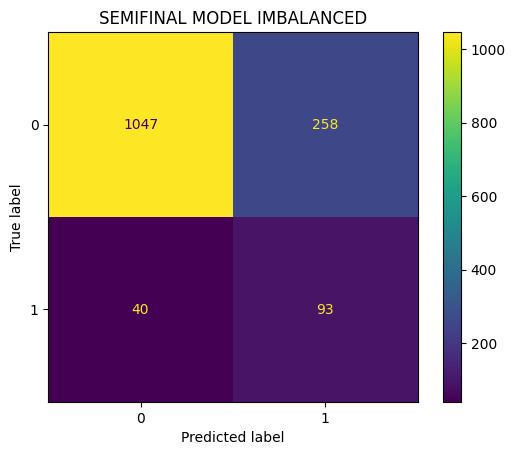

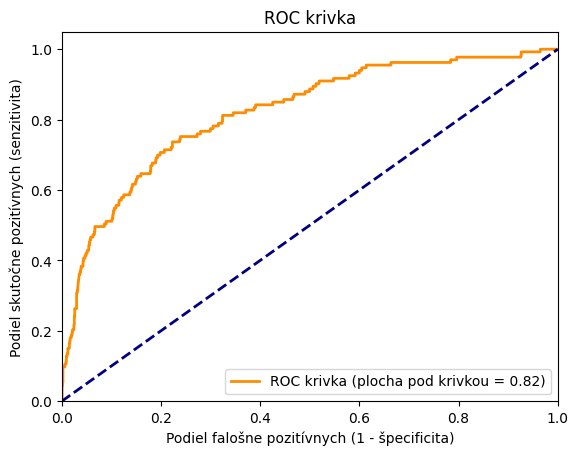

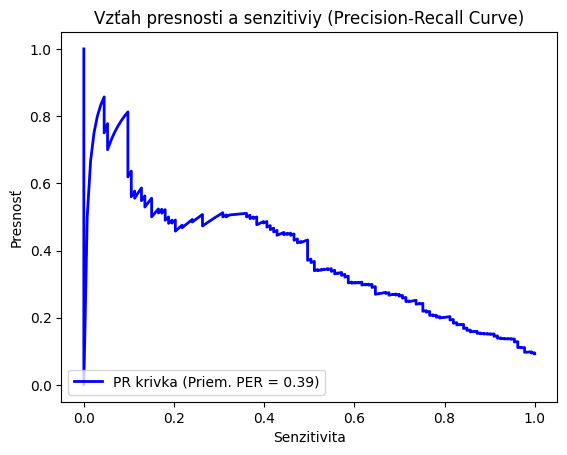

Threshold for 70% recall: 0.012930996488123096
Actual recall: 1.00
real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.6995827538247567
FINAL MODEL IMBALANCED Precision: 0.20512820512820512
FINAL MODEL IMBALANCED Recall: 0.7819548872180451
FINAL MODEL IMBALANCED Specificity: 0.6911877394636016
FINAL MODEL IMBALANCED F1 Score: 0.325


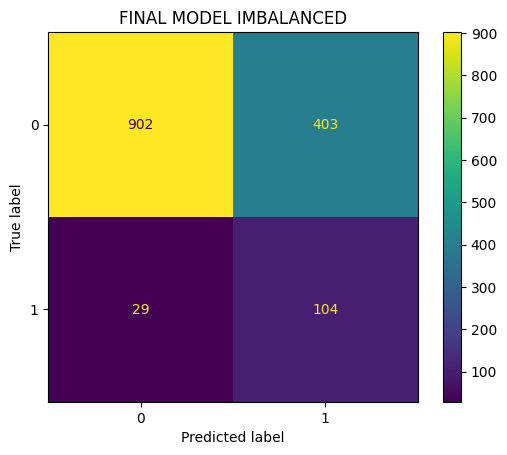

In [30]:

# Create an XGBoost classifier

mlp_classifier = MLPClassifier(
    random_state=37,
    activation= 'relu',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 5, 5),
    learning_rate = 'constant',
    max_iter = 1000,
    solver = 'adam'
    )

mlp_classifier.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_imbalanced, mlp_classifier.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = mlp_classifier.predict_proba(X_valid_valid_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()




# Find the threshold that achieves the target recall (70%)
target_recall = 0.70
threshold = thresholds[np.argmax(recall >= target_recall)]

# Predict using the new threshold
y_pred = (y_probs >= threshold).astype(int)

# Calculate the recall score with the new threshold
actual_recall = recall_score(y_valid_valid_imbalanced, y_pred)


print(f"Threshold for 70% recall: {threshold}")
print(f"Actual recall: {actual_recall:.2f}")




eval(y_valid_valid_imbalanced, predict_w_threshold(mlp_classifier, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.7628571428571429
FINAL MODEL TRAIN BALANCED Precision: 0.7216174183514774
FINAL MODEL TRAIN BALANCED Recall: 0.6628571428571428
FINAL MODEL TRAIN BALANCED Specificity: 0.8295238095238096
FINAL MODEL TRAIN BALANCED F1 Score: 0.6909903201787043


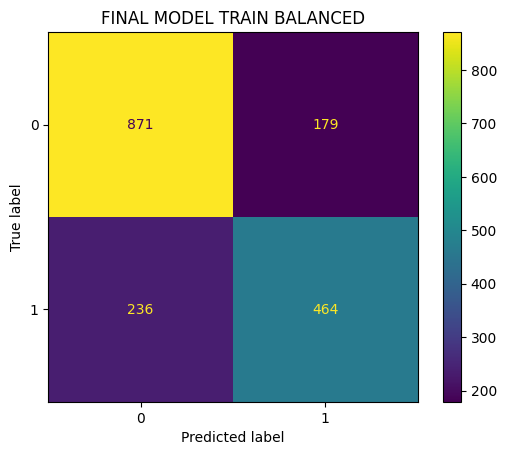

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7162790697674418
FINAL MODEL BALANCED Precision: 0.6524390243902439
FINAL MODEL BALANCED Recall: 0.622093023255814
FINAL MODEL BALANCED Specificity: 0.7790697674418605
FINAL MODEL BALANCED F1 Score: 0.6369047619047619


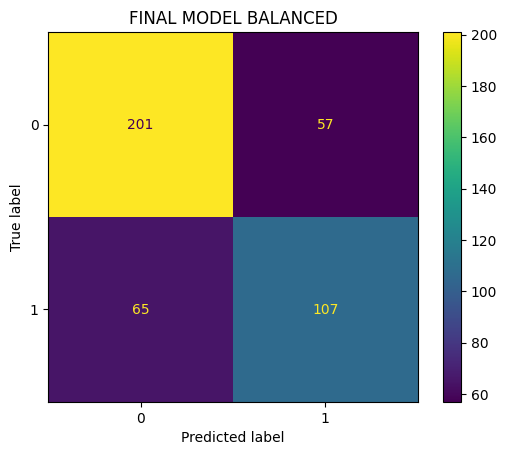

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7796327212020033
FINAL MODEL IMBALANCED Precision: 0.24429223744292236
FINAL MODEL IMBALANCED Recall: 0.622093023255814
FINAL MODEL IMBALANCED Specificity: 0.7963076923076923
FINAL MODEL IMBALANCED F1 Score: 0.3508196721311475


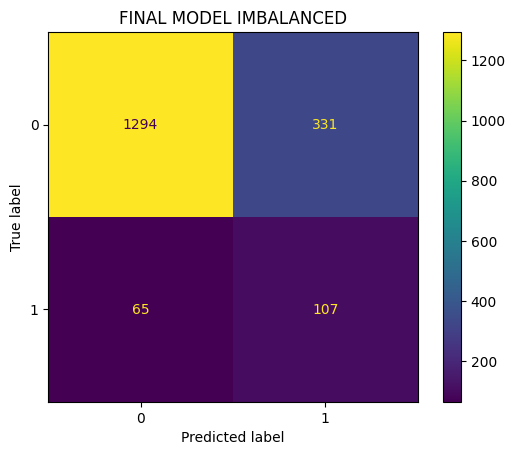

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7116279069767442
FINAL MODEL BALANCED Precision: 0.6276595744680851
FINAL MODEL BALANCED Recall: 0.686046511627907
FINAL MODEL BALANCED Specificity: 0.7286821705426356
FINAL MODEL BALANCED F1 Score: 0.6555555555555557


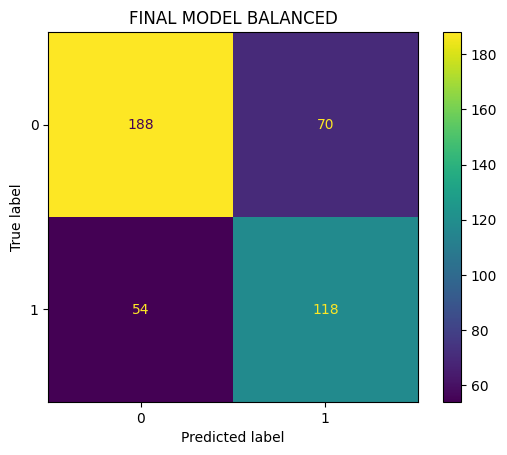

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7072899276572064
FINAL MODEL IMBALANCED Precision: 0.2
FINAL MODEL IMBALANCED Recall: 0.686046511627907
FINAL MODEL IMBALANCED Specificity: 0.7095384615384616
FINAL MODEL IMBALANCED F1 Score: 0.3097112860892388


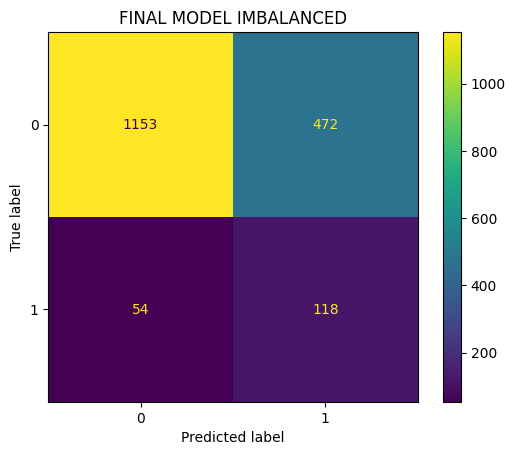

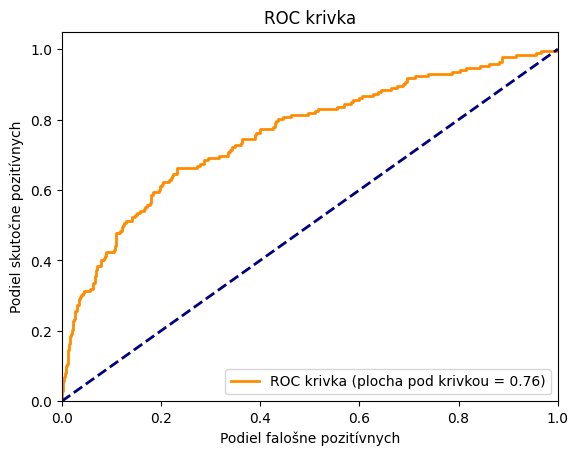

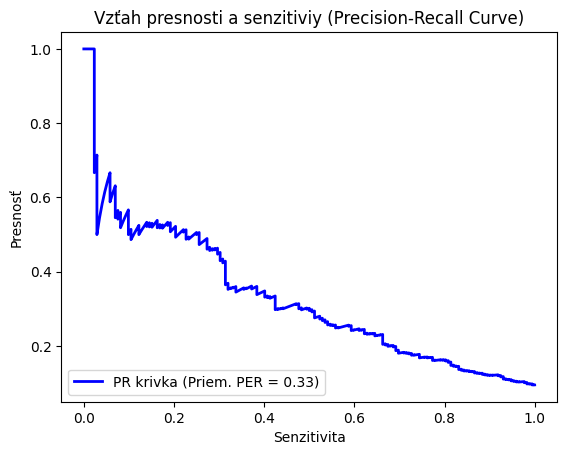

In [31]:
rf_final = MLPClassifier(
    random_state=37,
    activation= 'relu',
    alpha = 1e-05,
    hidden_layer_sizes = (5, 5, 5),
    learning_rate = 'constant',
    max_iter = 1000,
    solver = 'adam'
    )

rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

# Compute the AUC score
roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

# Compute average precision score
average_precision = average_precision_score(y_test_imbalanced, y_probs)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

